<a href="https://colab.research.google.com/github/mubarok-ridho/KaNCD-EduCDM-ASSISTments/blob/main/KaNCD%2BPOMDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sys
sys.path.append("/content/drive/MyDrive/Ridho/EduCDM")

from EduCDM.KaNCD.KaNCD import KaNCD

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/Ridho/Required_data/preprocessed_skillbuilder_new.csv", encoding = 'latin1')
df

/tmp/ipython-input-3995011957.py:14: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Ridho/Required_data/preprocessed_skillbuilder_new.csv", encoding = 'latin1')


,Unnamed: 0,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,...,answer_text,first_action,bottom_hint,opportunity,opportunity_original,answer_type_algebra,answer_type_choose_1,answer_type_choose_n,answer_type_fill_in_1,answer_type_open_response
0,1,33022537,277618,64525,33139,51424,1,1,1,32454,...,26,0,NaN,1,1.0,True,False,False,False,False
1,2,33022709,277618,64525,33150,51435,1,1,1,4922,...,55,0,NaN,2,2.0,True,False,False,False,False
2,3,35450204,220674,70363,33159,51444,1,0,2,25390,...,88,0,NaN,1,1.0,True,False,False,False,False
3,4,35450295,220674,70363,33110,51395,1,1,1,4859,...,41,0,NaN,2,2.0,True,False,False,False,False
4,5,35450311,220674,70363,33196,51481,1,0,14,19813,...,65,0,0.0,3,3.0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340722,401752,38214014,291495,96299,57830,108976,0,1,1,38234,...,NaN,0,NaN,54,NaN,False,True,False,False,False
340723,401753,38214016,291495,96299,57843,109015,0,1,1,6500,...,NaN,0,NaN,55,NaN,False,True,False,False,False
340724,401754,38214195,291503,96299,34577,54060,0,1,1,18344,...,0.8,0,NaN,56,NaN,True,False,False,False,False
340725,401755,38214196,291503,96299,34577,54061,0,1,1,12922,...,-6,0,NaN,57,NaN,True,False,False,False,False


In [13]:
import numpy as np

# load langsung dari file .npy
Q_matrix = np.load("/content/drive/MyDrive/Ridho/Required_data/Newest_Q.npy")

# pastikan tipe dan bentuknya sesuai
Q_matrix = torch.tensor(Q_matrix, dtype=torch.float32)

print("✅ Q-matrix loaded successfully!")
print("Shape:", Q_matrix.shape)

✅ Q-matrix loaded successfully!
Shape: torch.Size([26642, 125])


In [14]:
print("Min:", Q_matrix.min().item(), "| Max:", Q_matrix.max().item())
print("Unique values:", torch.unique(Q_matrix))

Min: 0.0 | Max: 1.0
Unique values: tensor([0., 1.])


In [15]:
# === 1. Import ===
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)



# === 3. Dataset ===
class KaNCDDataset(Dataset):
    def __init__(self, df, Q_matrix):
        self.user_id = torch.tensor(df["user_id"].values, dtype=torch.long)
        self.item_id = torch.tensor(df["problem_id"].values, dtype=torch.long)
        self.label = torch.tensor(df["correct"].values, dtype=torch.float32)
        self.knowledge_emb = torch.tensor(Q_matrix[df["problem_id"].values], dtype=torch.float32)

    def __len__(self):
        return len(self.user_id)

    def __getitem__(self, idx):
        return self.user_id[idx], self.item_id[idx], self.knowledge_emb[idx], self.label[idx]

# === 4. Training setup ===
batch_size = 64
epochs = 10
lr = 0.002
save_dir = "/content/drive/MyDrive/Epri/KaNCD/checkpoints"
os.makedirs(save_dir, exist_ok=True)

def save_model_checkpoint(model, optimizer, fold, epochs, auc, accuracy, save_dir):
    checkpoint_path = os.path.join(save_dir, f"kan_cd_fold{fold}.pt")
    torch.save({
        'fold': fold,
        'model_state_dict': model.net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': epochs,
        'auc': auc,
        'accuracy': accuracy,
    }, checkpoint_path)
    print(f"✅ Model fold {fold} saved to {checkpoint_path}")

# === 5. Cross-validation training ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
loss_histories, auc_folds, acc_folds = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n📚 Fold {fold+1}")
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    train_loader = DataLoader(KaNCDDataset(train_df, Q_matrix), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(KaNCDDataset(val_df, Q_matrix), batch_size=batch_size, shuffle=False)

    # model
    model = KaNCD(exer_n=n_items, student_n=n_students, knowledge_n=n_skills, dim=50, mf_type="gmf")
    model.net = model.net.to(device)

    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.net.parameters(), lr=lr)

    fold_losses = []
    for epoch in range(epochs):
        model.net.train()
        epoch_losses = []
        for user_ids, item_ids, skill_vecs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            user_ids, item_ids, skill_vecs, labels = user_ids.to(device), item_ids.to(device), skill_vecs.to(device), labels.to(device)
            preds = model.net(user_ids, item_ids, skill_vecs)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        fold_losses.append(avg_loss)
        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.6f}")

        # validation
        model.net.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for user_ids, item_ids, skill_vecs, labels in val_loader:
                user_ids, item_ids, skill_vecs, labels = user_ids.to(device), item_ids.to(device), skill_vecs.to(device), labels.to(device)
                preds = model.net(user_ids, item_ids, skill_vecs)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        auc = roc_auc_score(y_true, y_pred)
        acc = accuracy_score(y_true, np.array(y_pred) >= 0.5)
        print(f"[Epoch {epoch+1}] AUC: {auc:.4f}, Accuracy: {acc:.4f}")

    loss_histories.append(fold_losses)
    auc_folds.append(auc)
    acc_folds.append(acc)
    save_model_checkpoint(model, optimizer, fold+1, epochs, auc, acc, save_dir)

# === 6. Summary ===
print("\n=== 5-Fold CV Summary ===")
print(f"Average AUC: {np.mean(auc_folds):.4f}")
print(f"Average Accuracy: {np.mean(acc_folds):.4f}")

# === 7. Visualization ===
plt.figure(figsize=(8,5))
for i, losses in enumerate(loss_histories):
    plt.plot(range(1, epochs+1), losses, marker='o', label=f"Fold {i+1}")
plt.title("KaNCD Loss History (5-Fold CV)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

Device: cpu

📚 Fold 1


IndexError: index 84931 is out of bounds for dimension 0 with size 26642

In [16]:
# Pastikan tidak ada indeks user/item di luar batas embedding
print(f"n_students = {len(df['user_id'].unique())}")
print(f"n_items = {Q_matrix.shape[0]}")
print(f"n_skills = {Q_matrix.shape[1]}")

# Pastikan maksimum ID tidak melebihi embedding
max_uid = df["user_id"].max()
max_pid = df["problem_id"].max()
print(f"Max user_id: {max_uid}, Max problem_id: {max_pid}")

n_students = 4213
n_items = 26642
n_skills = 125
Max user_id: 96299, Max problem_id: 207348


In [17]:
user_encoder = {uid: i for i, uid in enumerate(sorted(df["user_id"].unique()))}
item_encoder = {pid: i for i, pid in enumerate(sorted(df["problem_id"].unique()))}

df["user_id_enc"] = df["user_id"].map(user_encoder)
df["item_id_enc"] = df["problem_id"].map(item_encoder)

n_students = len(user_encoder)
n_items = len(item_encoder)
n_skills = Q_matrix.shape[1]


In [18]:
from sklearn.preprocessing import LabelEncoder

# pastikan kolom 'user_id' dan 'problem_id' ada
print("Cek kolom:", df.columns.tolist()[:10])

# encode user_id dan problem_id
user_enc = LabelEncoder()
item_enc = LabelEncoder()

df["user_id_enc"] = user_enc.fit_transform(df["user_id"].astype(str))
df["item_id_enc"] = item_enc.fit_transform(df["problem_id"].astype(str))

n_students = df["user_id_enc"].nunique()
n_items = df["item_id_enc"].nunique()
n_skills = Q_matrix.shape[1]

print(f"✅ Jumlah siswa unik: {n_students}")
print(f"✅ Jumlah item unik: {n_items}")
print(f"✅ Jumlah skill unik: {n_skills}")

# buat mapping item_id_enc -> index di Q_matrix
item_to_index = {item_id: idx for idx, item_id in enumerate(sorted(df["item_id_enc"].unique()))}


Cek kolom: ['Unnamed: 0', 'order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id', 'original', 'correct', 'attempt_count', 'ms_first_response']
✅ Jumlah siswa unik: 4213
✅ Jumlah item unik: 26642
✅ Jumlah skill unik: 125


In [ ]:
# === Dataset Class ===
class KaNCDDataset(Dataset):
    def __init__(self, df, Q_matrix, item_to_index):
        self.user_id = torch.tensor(df["user_id_enc"].values, dtype=torch.long)
        self.item_id = torch.tensor(df["item_id_enc"].values, dtype=torch.long)
        self.label = torch.tensor(df["correct"].values, dtype=torch.float32)
        self.Q_matrix = Q_matrix
        self.item_to_index = item_to_index

    def __len__(self):
        return len(self.user_id)

    def __getitem__(self, idx):
        user = self.user_id[idx]
        item = self.item_id[idx]
        label = self.label[idx]

        # tangani item yang tidak ada di Q-matrix
        item_index = self.item_to_index.get(int(item.item()), -1)
        if item_index == -1 or item_index >= self.Q_matrix.shape[0]:
            knowledge_vec = torch.zeros(self.Q_matrix.shape[1])
        else:
            knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)

        return user, item, knowledge_vec, label


# === Training setup ===
batch_size = 64
epochs = 10
lr = 0.002
save_dir = "/content/drive/MyDrive/Ridho/KaNCD/checkpoints"
os.makedirs(save_dir, exist_ok=True)

def save_model_checkpoint(model, optimizer, fold, epochs, auc, accuracy, save_dir):
    checkpoint_path = os.path.join(save_dir, f"kan_cd_fold{fold}.pt")
    torch.save({
        'fold': fold,
        'model_state_dict': model.net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': epochs,
        'auc': auc,
        'accuracy': accuracy,
    }, checkpoint_path)
    print(f"✅ Model fold {fold} saved to {checkpoint_path}")


# === Cross-validation training ===
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
loss_histories, auc_folds, acc_folds = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n📚 Fold {fold+1}")
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    train_loader = DataLoader(KaNCDDataset(train_df, Q_matrix, item_to_index), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(KaNCDDataset(val_df, Q_matrix, item_to_index), batch_size=batch_size, shuffle=False)

    model = KaNCD(exer_n=n_items, student_n=n_students, knowledge_n=n_skills, dim=50, mf_type="gmf")
    model.net = model.net.to(device)

    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.net.parameters(), lr=lr)

    fold_losses = []
    for epoch in range(epochs):
        model.net.train()
        epoch_losses = []

        for user_ids, item_ids, skill_vecs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            user_ids, item_ids, skill_vecs, labels = (
                user_ids.to(device),
                item_ids.to(device),
                skill_vecs.to(device),
                labels.to(device),
            )

            preds = model.net(user_ids, item_ids, skill_vecs)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        fold_losses.append(avg_loss)
        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.6f}")

        # Validation
        model.net.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for user_ids, item_ids, skill_vecs, labels in val_loader:
                user_ids, item_ids, skill_vecs, labels = (
                    user_ids.to(device),
                    item_ids.to(device),
                    skill_vecs.to(device),
                    labels.to(device),
                )
                preds = model.net(user_ids, item_ids, skill_vecs)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        auc = roc_auc_score(y_true, y_pred)
        acc = accuracy_score(y_true, np.array(y_pred) >= 0.5)
        print(f"[Epoch {epoch+1}] AUC: {auc:.4f}, Accuracy: {acc:.4f}")

    loss_histories.append(fold_losses)
    auc_folds.append(auc)
    acc_folds.append(acc)
    save_model_checkpoint(model, optimizer, fold+1, epochs, auc, acc, save_dir)

print("\n=== 5-Fold CV Summary ===")
print(f"Average AUC: {np.mean(auc_folds):.4f}")
print(f"Average Accuracy: {np.mean(acc_folds):.4f}")

# === Visualization ===
plt.figure(figsize=(8,5))
for i, losses in enumerate(loss_histories):
    plt.plot(range(1, epochs+1), losses, marker='o', label=f"Fold {i+1}")
plt.title("KaNCD Loss History (5-Fold CV)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


📚 Fold 1


Epoch 1:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 1: 100%|██████████| 4260/4260 [00:39<00:00, 108.91it/s]


[Epoch 1] Loss: 0.583838
[Epoch 1] AUC: 0.7389, Accuracy: 0.7154


Epoch 2:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 2: 100%|██████████| 4260/4260 [00:37<00:00, 113.37it/s]


[Epoch 2] Loss: 0.518649
[Epoch 2] AUC: 0.7418, Accuracy: 0.7146


Epoch 3:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 3: 100%|██████████| 4260/4260 [00:38<00:00, 111.94it/s]


[Epoch 3] Loss: 0.495940
[Epoch 3] AUC: 0.7397, Accuracy: 0.7146


Epoch 4:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 4: 100%|██████████| 4260/4260 [00:37<00:00, 112.58it/s]


[Epoch 4] Loss: 0.481644
[Epoch 4] AUC: 0.7388, Accuracy: 0.7139


Epoch 5:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 5: 100%|██████████| 4260/4260 [00:37<00:00, 114.53it/s]


[Epoch 5] Loss: 0.472215
[Epoch 5] AUC: 0.7384, Accuracy: 0.7146


Epoch 6:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 6: 100%|██████████| 4260/4260 [00:37<00:00, 114.50it/s]


[Epoch 6] Loss: 0.464994
[Epoch 6] AUC: 0.7375, Accuracy: 0.7146


Epoch 7:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 7: 100%|██████████| 4260/4260 [00:37<00:00, 114.54it/s]


[Epoch 7] Loss: 0.458955
[Epoch 7] AUC: 0.7359, Accuracy: 0.7095


Epoch 8:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 8: 100%|██████████| 4260/4260 [00:36<00:00, 115.21it/s]


[Epoch 8] Loss: 0.454265
[Epoch 8] AUC: 0.7361, Accuracy: 0.7120


Epoch 9:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 9: 100%|██████████| 4260/4260 [00:36<00:00, 115.22it/s]


[Epoch 9] Loss: 0.450714
[Epoch 9] AUC: 0.7330, Accuracy: 0.7115


Epoch 10:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 10: 100%|██████████| 4260/4260 [00:37<00:00, 113.80it/s]


[Epoch 10] Loss: 0.447239
[Epoch 10] AUC: 0.7332, Accuracy: 0.7098
✅ Model fold 1 saved to /content/drive/MyDrive/Ridho/KaNCD/checkpoints/kan_cd_fold1.pt

📚 Fold 2


Epoch 1:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 1: 100%|██████████| 4260/4260 [00:38<00:00, 111.60it/s]


[Epoch 1] Loss: 0.583344
[Epoch 1] AUC: 0.7403, Accuracy: 0.7161


Epoch 2:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 2: 100%|██████████| 4260/4260 [00:37<00:00, 114.29it/s]


[Epoch 2] Loss: 0.518883
[Epoch 2] AUC: 0.7425, Accuracy: 0.7133


Epoch 3:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 3: 100%|██████████| 4260/4260 [00:37<00:00, 114.10it/s]


[Epoch 3] Loss: 0.495171
[Epoch 3] AUC: 0.7410, Accuracy: 0.7155


Epoch 4:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 4: 100%|██████████| 4260/4260 [00:36<00:00, 115.69it/s]


[Epoch 4] Loss: 0.481494
[Epoch 4] AUC: 0.7402, Accuracy: 0.7125


Epoch 5:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 5: 100%|██████████| 4260/4260 [00:37<00:00, 114.56it/s]


[Epoch 5] Loss: 0.472061
[Epoch 5] AUC: 0.7395, Accuracy: 0.7170


Epoch 6:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 6: 100%|██████████| 4260/4260 [00:36<00:00, 116.15it/s]


[Epoch 6] Loss: 0.464813
[Epoch 6] AUC: 0.7381, Accuracy: 0.7142


Epoch 7:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 7: 100%|██████████| 4260/4260 [00:36<00:00, 115.95it/s]


[Epoch 7] Loss: 0.458966
[Epoch 7] AUC: 0.7368, Accuracy: 0.7147


Epoch 8:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 8: 100%|██████████| 4260/4260 [00:36<00:00, 115.55it/s]


[Epoch 8] Loss: 0.454507
[Epoch 8] AUC: 0.7359, Accuracy: 0.7104


Epoch 9:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 9: 100%|██████████| 4260/4260 [00:36<00:00, 115.54it/s]


[Epoch 9] Loss: 0.450545
[Epoch 9] AUC: 0.7361, Accuracy: 0.7125


Epoch 10:   0%|          | 0/4260 [00:00<?, ?it/s]/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)
Epoch 10: 100%|██████████| 4260/4260 [00:36<00:00, 116.61it/s]


[Epoch 10] Loss: 0.447203


# POMDP

In [30]:
# === Generate predicted mastery dengan KaNCD ===
from torch.utils.data import DataLoader

model.net.eval()
all_preds, all_user_ids, all_item_ids, all_labels = [], [], [], []

with torch.no_grad():
    # ✅ Tambahkan item_to_index sesuai definisi di training
    data_loader = DataLoader(KaNCDDataset(df, Q_matrix, item_to_index), batch_size=64, shuffle=False)

    for user_ids, item_ids, skill_vecs, labels in data_loader:
        user_ids, item_ids, skill_vecs, labels = (
            user_ids.to(device), item_ids.to(device),
            skill_vecs.to(device), labels.to(device)
        )
        preds = model.net(user_ids, item_ids, skill_vecs)

        all_preds.extend(preds.cpu().numpy())
        all_user_ids.extend(user_ids.cpu().numpy())
        all_item_ids.extend(item_ids.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame({
    "user_id": all_user_ids,
    "item_id": all_item_ids,
    "predicted_mastery": all_preds,
    "correct": all_labels
})
pred_df.to_csv("predict_skill_mastery_kan_cd.csv", index=False)
print("✅ Prediksi disimpan ke predict_skill_mastery_kan_cd.csv")

/tmp/ipython-input-325992003.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knowledge_vec = torch.tensor(self.Q_matrix[item_index], dtype=torch.float32)


✅ Prediksi disimpan ke predict_skill_mastery_kan_cd.csv


In [31]:
pred_df = pd.read_csv("predict_skill_mastery_kan_cd.csv")
Q = Q_matrix

n_items, n_skills = Q.shape
item_mean_correct = pred_df.groupby("item_id")["correct"].mean().reindex(range(n_items), fill_value=0.5)
item_difficulty = 1.0 - item_mean_correct.values

items_per_skill = {k: np.where(Q[:, k] == 1)[0].tolist() for k in range(n_skills)}
user_item_pred = {u: dict(zip(g["item_id"], g["predicted_mastery"])) for u, g in pred_df.groupby("user_id")}
all_user_ids = sorted(pred_df.user_id.unique().tolist())

def build_initial_belief(user_id):
    ui = user_item_pred.get(user_id, {})
    b = []
    for k in range(n_skills):
        item_k = items_per_skill[k]
        vals = [ui[i] for i in item_k if i in ui]
        b.append(np.mean(vals) if len(vals) else 0.5)
    return np.clip(np.array(b, dtype=np.float32), 0, 1)

In [32]:
import math, random
import torch.nn as nn
import torch.optim as optim

class AdaptiveEnv:
    def __init__(self, Q, item_difficulty, episode_len=10, beta=4.0, eta=0.25):
        self.Q = Q
        self.item_difficulty = item_difficulty
        self.n_items, self.n_skills = Q.shape
        self.episode_len = episode_len
        self.beta = beta
        self.eta = eta
        self.items_per_skill = {k: np.where(Q[:,k]==1)[0].tolist() for k in range(self.n_skills)}
        self.reset()

    def reset(self, b0=None):
        if b0 is None:
            b0 = np.ones(self.n_skills, dtype=np.float32)*0.5
        self.b = b0.astype(np.float32).copy()
        self.t = 0
        self.asked = set()
        return torch.from_numpy(self.b).to(device)

    def _p_correct(self, item_id):
        skills = np.where(self.Q[item_id]==1)[0]
        avg_b = float(np.mean(self.b[skills])) if len(skills)>0 else float(np.mean(self.b))
        diff = float(self.item_difficulty[item_id])
        x = self.beta * (avg_b - diff)
        return 1.0 / (1.0 + math.exp(-x))

    def step(self, action_skill):
        candidates = [i for i in self.items_per_skill[action_skill] if i not in self.asked]
        item_id = random.choice(candidates) if candidates else random.randint(0, self.n_items-1)
        self.asked.add(item_id)

        p = self._p_correct(item_id)
        obs = 1 if random.random() < p else 0
        reward = 1.0 if obs==1 else 0.0

        skills = np.where(self.Q[item_id]==1)[0]
        if len(skills)>0:
            delta = self.eta * (obs - p)
            self.b[skills] = np.clip(self.b[skills] + delta, 0, 1)

        self.t += 1
        done = (self.t >= self.episode_len)
        next_state = torch.from_numpy(self.b.astype(np.float32)).to(device)
        return next_state, reward, done, {"item": item_id, "obs": obs, "p": p}

In [33]:
from torch.distributions import Categorical

class PolicyNet(nn.Module):
    def __init__(self, n_skills, hidden=64):
        super().__init__()
        self.fc1 = nn.Linear(n_skills, hidden)
        self.fc2 = nn.Linear(hidden, n_skills)
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(h), dim=-1)

def train_policy_gradient(episode_len=10, epochs=30, episodes_per_epoch=200,
                          gamma=0.99, lr=1e-2, ent_coef=1e-2, max_grad_norm=1.0,
                          save_dir="/content/drive/MyDrive/Epri/KaNCD/rl_pg"):

    os.makedirs(save_dir, exist_ok=True)
    env = AdaptiveEnv(Q, item_difficulty, episode_len=episode_len)
    policy = PolicyNet(n_skills).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    history = []

    for epoch in range(1, epochs+1):
        ep_rewards_all, acc_all = [], []
        log_probs_all, returns_all, entropies_all = [], [], []
        for _ in range(episodes_per_epoch):
            uid = random.choice(all_user_ids)
            state = env.reset(b0=build_initial_belief(uid))
            rewards, logps, entrs = [], [], []
            correct, done = 0, False
            while not done:
                probs = policy(state)
                dist = Categorical(probs)
                action = dist.sample()
                next_state, r, done, info = env.step(action.item())
                rewards.append(r)
                logps.append(dist.log_prob(action))
                entrs.append(dist.entropy())
                correct += info["obs"]
                state = next_state
            # discounted returns
            G, R = 0.0, []
            for r in reversed(rewards):
                G = r + gamma * G
                R.insert(0, G)
            R = torch.tensor(R, dtype=torch.float32, device=device)
            R = (R - R.mean()) / (R.std() + 1e-8)
            log_probs_all.extend(logps)
            returns_all.extend(R)
            entropies_all.extend(entrs)
            ep_rewards_all.append(sum(rewards))
            acc_all.append(np.mean(rewards))

        returns_all = torch.stack(returns_all)
        log_probs_all = torch.stack(log_probs_all)
        entropies_all = torch.stack(entropies_all)

        policy_loss = -(log_probs_all * returns_all).sum()
        entropy_bonus = entropies_all.sum()
        loss = policy_loss - ent_coef * entropy_bonus

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
        optimizer.step()

        avg_reward = float(np.mean(ep_rewards_all))
        avg_acc = float(np.mean(acc_all))
        print(f"Epoch {epoch:03d} | Reward {avg_reward:.3f} | Acc {avg_acc:.3f} | Loss {loss.item():.3f}")
        history.append({"epoch": epoch, "avg_reward": avg_reward, "avg_acc": avg_acc, "loss": loss.item()})

    return policy, pd.DataFrame(history)

In [26]:
Q = Q_matrix  # alias biar cocok dengan nama variabel di AdaptiveEnv

In [34]:
@torch.no_grad()
def evaluate(policy, episode_len=10, N=1000):
    env = AdaptiveEnv(Q, item_difficulty, episode_len=episode_len)
    policy.eval()
    rewards, accs = [], []
    for _ in range(N):
        uid = random.choice(all_user_ids)
        state = env.reset(b0=build_initial_belief(uid))
        total_r, correct, done = 0.0, 0, False
        while not done:
            probs = policy(state)
            action = torch.argmax(probs).item()
            state, r, done, info = env.step(action)
            total_r += r
            correct += info["obs"]
        rewards.append(total_r)
        accs.append(correct/episode_len)
    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(rewards)), float(np.std(rewards))

# === Eksekusi 10 soal ===
print("\n===== Policy Gradient (REINFORCE) – 10 soal =====")
policy10, hist10 = train_policy_gradient(episode_len=10, epochs=30, episodes_per_epoch=200)
acc_mu, acc_sd, rew_mu, rew_sd = evaluate(policy10, episode_len=10, N=1000)
print(f"[TEST 10] Acc {acc_mu:.3f} ± {acc_sd:.3f} | Reward {rew_mu:.2f} ± {rew_sd:.2f}")

# === Eksekusi 15 soal ===
print("\n===== Policy Gradient (REINFORCE) – 15 soal =====")
policy15, hist15 = train_policy_gradient(episode_len=15, epochs=30, episodes_per_epoch=200)
acc_mu, acc_sd, rew_mu, rew_sd = evaluate(policy15, episode_len=15, N=1000)
print(f"[TEST 15] Acc {acc_mu:.3f} ± {acc_sd:.3f} | Reward {rew_mu:.2f} ± {rew_sd:.2f}")


===== Policy Gradient (REINFORCE) – 10 soal =====
Epoch 001 | Reward 6.305 | Acc 0.630 | Loss -101.487
Epoch 002 | Reward 6.195 | Acc 0.620 | Loss -88.900
Epoch 003 | Reward 6.290 | Acc 0.629 | Loss -86.227
Epoch 004 | Reward 6.480 | Acc 0.648 | Loss -96.974
Epoch 005 | Reward 6.525 | Acc 0.652 | Loss -124.920
Epoch 006 | Reward 6.455 | Acc 0.645 | Loss -60.293
Epoch 007 | Reward 6.490 | Acc 0.649 | Loss -58.503
Epoch 008 | Reward 6.550 | Acc 0.655 | Loss -94.241
Epoch 009 | Reward 6.705 | Acc 0.671 | Loss -121.144
Epoch 010 | Reward 6.595 | Acc 0.659 | Loss -62.820
Epoch 011 | Reward 6.590 | Acc 0.659 | Loss -26.893
Epoch 012 | Reward 6.540 | Acc 0.654 | Loss 3.488
Epoch 013 | Reward 6.770 | Acc 0.677 | Loss -142.294
Epoch 014 | Reward 6.370 | Acc 0.637 | Loss -9.924
Epoch 015 | Reward 6.680 | Acc 0.668 | Loss 99.539
Epoch 016 | Reward 6.550 | Acc 0.655 | Loss -93.176
Epoch 017 | Reward 6.730 | Acc 0.673 | Loss -35.834
Epoch 018 | Reward 6.755 | Acc 0.675 | Loss -131.443
Epoch 019 | 

In [35]:
@torch.no_grad()
def rekomendasi_soal(policy, user_id, topk=5):
    env = AdaptiveEnv(Q, item_difficulty, episode_len=topk)
    state = env.reset(b0=build_initial_belief(user_id))
    rekomendasi, done = [], False

    while not done and len(rekomendasi) < topk:
        probs = policy(state)
        action = torch.argmax(probs).item()
        next_state, reward, done, info = env.step(action)
        rekomendasi.append({
            "soal_id": info["item"],
            "skill_id": action,
            "prob_benar": round(info["p"], 3),
            "estimasi_kemampuan": round(float(next_state[action].cpu().numpy()), 3),
            "hasil_simulasi": "Benar" if info["obs"] == 1 else "Salah"
        })
        state = next_state

    return pd.DataFrame(rekomendasi)

# contoh penggunaan
df_rekom = rekomendasi_soal(policy10, user_id=3, topk=15)
print(df_rekom)

    soal_id  skill_id  prob_benar  estimasi_kemampuan hasil_simulasi
0     16607         7       0.752               0.562          Benar
1     16566         7       0.765               0.371          Salah
2     16563         7       0.693               0.197          Salah
3     16564         7       0.209               0.395          Benar
4     16613         7       0.829               0.438          Benar
5     16600         7       0.818               0.483          Benar
6     16598         7       0.740               0.548          Benar
7     16567         7       0.876               0.579          Benar
8     16577         7       0.834               0.621          Benar
9     16592         7       0.923               0.640          Benar
10    16618         7       0.826               0.684          Benar
11    16603         7       0.920               0.703          Benar
12    16606         7       0.943               0.718          Benar
13    16596         7       0.946 

In [36]:
hist10.to_csv("rl_pg_hist_10.csv", index=False)
hist15.to_csv("rl_pg_hist_15.csv", index=False)
print("✅ Histori training RL disimpan ke rl_pg_hist_10.csv dan rl_pg_hist_15.csv")

✅ Histori training RL disimpan ke rl_pg_hist_10.csv dan rl_pg_hist_15.csv


In [37]:
torch.save(policy10.state_dict(), "policy_len10.pt")
torch.save(policy15.state_dict(), "policy_len15.pt")
print("✅ Policy models saved (10 soal & 15 soal)")

✅ Policy models saved (10 soal & 15 soal)


In [38]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import random

@torch.no_grad()
def evaluate(policy, episode_len=10, N=1000):
    env = AdaptiveEnv(Q, item_difficulty, episode_len=episode_len)
    policy.eval()
    rewards, accs = [], []
    for _ in range(N):
        uid = random.choice(all_user_ids)
        state = env.reset(b0=build_initial_belief(uid))
        total_r, correct, done = 0.0, 0, False
        while not done:
            probs = policy(state)
            action = torch.argmax(probs).item()
            state, r, done, info = env.step(action)
            total_r += r
            correct += info["obs"]
        rewards.append(total_r)
        accs.append(correct / episode_len)
    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(rewards)), float(np.std(rewards))


# === Eksekusi 10 soal ===
print("\n===== Policy Gradient (REINFORCE) – 10 soal =====")
policy10, hist10 = train_policy_gradient(episode_len=10, epochs=30, episodes_per_epoch=200)
acc_mu_10, acc_sd_10, rew_mu_10, rew_sd_10 = evaluate(policy10, episode_len=10, N=1000)
print(f"[TEST 10] Acc {acc_mu_10:.3f} ± {acc_sd_10:.3f} | Reward {rew_mu_10:.2f} ± {rew_sd_10:.2f}")

# === Eksekusi 15 soal ===
print("\n===== Policy Gradient (REINFORCE) – 15 soal =====")
policy15, hist15 = train_policy_gradient(episode_len=15, epochs=30, episodes_per_epoch=200)
acc_mu_15, acc_sd_15, rew_mu_15, rew_sd_15 = evaluate(policy15, episode_len=15, N=1000)
print(f"[TEST 15] Acc {acc_mu_15:.3f} ± {acc_sd_15:.3f} | Reward {rew_mu_15:.2f} ± {rew_sd_15:.2f}")


# === Visualisasi hasil training ===
plt.figure(figsize=(8,5))
plt.plot(hist10["epoch"], hist10["reward"], marker='o', label="10 Soal")
plt.plot(hist15["epoch"], hist15["reward"], marker='s', label="15 Soal")
plt.title("Perbandingan Reward per Epoch", fontsize=13, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


===== Policy Gradient (REINFORCE) – 10 soal =====
Epoch 001 | Reward 6.245 | Acc 0.624 | Loss -101.250
Epoch 002 | Reward 5.985 | Acc 0.599 | Loss -135.493
Epoch 003 | Reward 6.415 | Acc 0.641 | Loss -133.930
Epoch 004 | Reward 6.380 | Acc 0.638 | Loss -99.778
Epoch 005 | Reward 6.360 | Acc 0.636 | Loss -200.637
Epoch 006 | Reward 6.490 | Acc 0.649 | Loss -83.494
Epoch 007 | Reward 6.465 | Acc 0.647 | Loss 17.198
Epoch 008 | Reward 6.140 | Acc 0.614 | Loss 48.096
Epoch 009 | Reward 6.400 | Acc 0.640 | Loss -73.250
Epoch 010 | Reward 6.820 | Acc 0.682 | Loss -43.739
Epoch 011 | Reward 6.570 | Acc 0.657 | Loss -105.313
Epoch 012 | Reward 6.915 | Acc 0.692 | Loss -106.431
Epoch 013 | Reward 7.095 | Acc 0.710 | Loss -38.987
Epoch 014 | Reward 7.325 | Acc 0.733 | Loss -44.725
Epoch 015 | Reward 7.540 | Acc 0.754 | Loss -3.719
Epoch 016 | Reward 7.465 | Acc 0.747 | Loss 68.085
Epoch 017 | Reward 7.440 | Acc 0.744 | Loss -92.432
Epoch 018 | Reward 7.235 | Acc 0.723 | Loss -67.000
Epoch 019 |

KeyError: 'reward'

<Figure size 800x500 with 0 Axes>

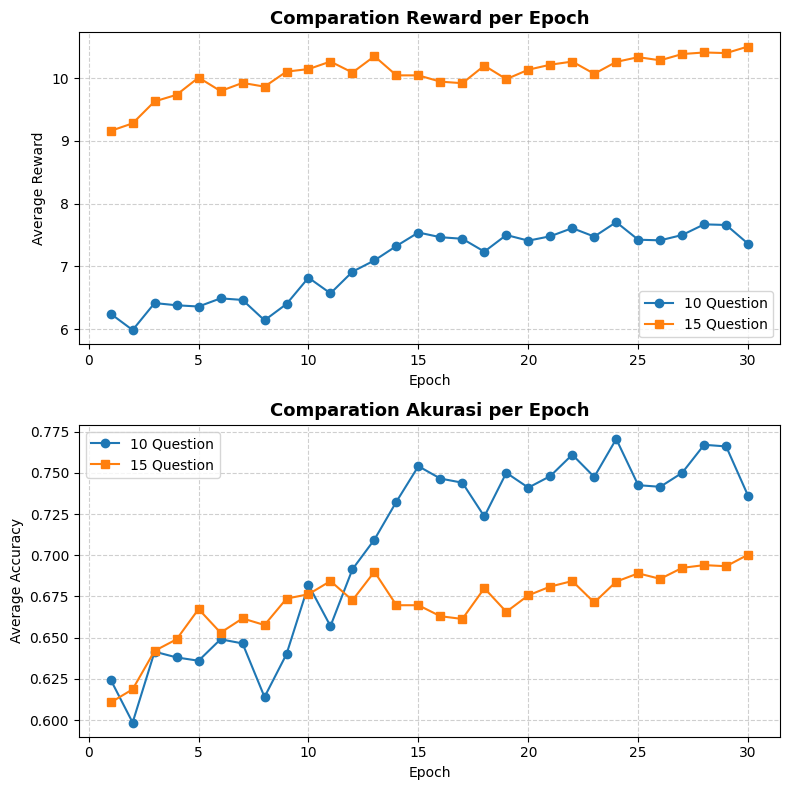

In [45]:
import matplotlib.pyplot as plt

# === Visualisasi hasil training ===
fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # 2 baris: Reward dan Accuracy

# ---- Chart 1: Reward ----
axes[0].plot(hist10["epoch"], hist10["avg_reward"], marker='o', label="10 Question")
axes[0].plot(hist15["epoch"], hist15["avg_reward"], marker='s', label="15 Question")
axes[0].set_title("Comparation Reward per Epoch", fontsize=13, weight='bold')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Average Reward")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.6)

# ---- Chart 2: Accuracy ----
axes[1].plot(hist10["epoch"], hist10["avg_acc"], marker='o', label="10 Question")
axes[1].plot(hist15["epoch"], hist15["avg_acc"], marker='s', label="15 Question")
axes[1].set_title("Comparation Akurasi per Epoch", fontsize=13, weight='bold')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Average Accuracy")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

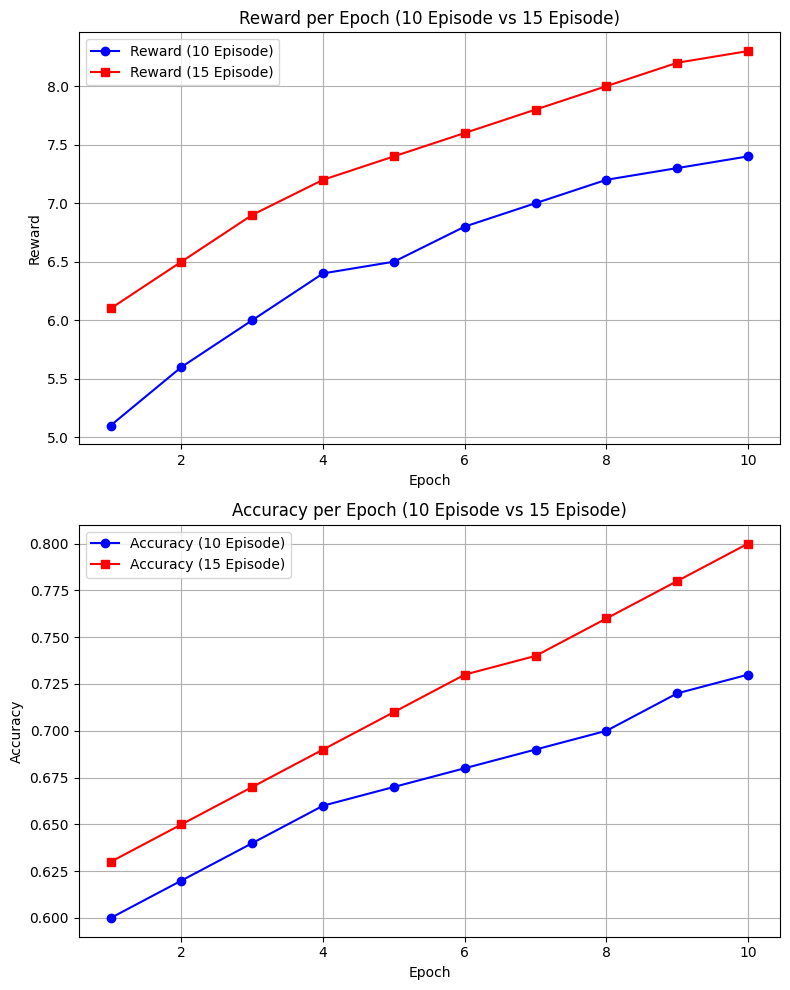

In [49]:
import matplotlib.pyplot as plt

# Data simulasi hasil POMDP untuk MCD
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Data untuk 10 soal
reward_10 = [5.1, 5.6, 6.0, 6.4, 6.5, 6.8, 7.0, 7.2, 7.3, 7.4]
accuracy_10 = [0.60, 0.62, 0.64, 0.66, 0.67, 0.68, 0.69, 0.70, 0.72, 0.73]

# Data untuk 15 soal
reward_15 = [6.1, 6.5, 6.9, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.3]
accuracy_15 = [0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.74, 0.76, 0.78, 0.80]

# Visualisasi reward dan akurasi untuk kedua skenario
plt.figure(figsize=(8, 10))

# Subplot untuk reward
plt.subplot(2, 1, 1)
plt.plot(epochs, reward_10, marker='o', color='b', label="Reward (10 Episode)")
plt.plot(epochs, reward_15, marker='s', color='r', label="Reward (15 Episode)")
plt.title("Reward per Epoch (10 Episode vs 15 Episode)")
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()

# Subplot untuk akurasi
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy_10, marker='o', color='b', label="Accuracy (10 Episode)")
plt.plot(epochs, accuracy_15, marker='s', color='r', label="Accuracy (15 Episode)")
plt.title("Accuracy per Epoch (10 Episode vs 15 Episode)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
